# Notebook compare clustering metrics of *"individual vs. integrated"* and *"single cell vs. Pseudobulk"*

## Imports

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
#sc.settings.figdir = '/work/sduknn/Andreas/TM_MCA/figures'
#sc.settings.figdir = '/work/sduknn/Andreas/TM_MCA/new_new_figures2'
#output_dir = "/work/sduknn/Andreas/TM_MCA/new_new_figures2"
import matplotlib



from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
# settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=True)

In [3]:
# load mapping table
mapping_df = pd.read_csv('/work/sduknn/Andreas/TM_MCA/database_SCENIC/tmp/color_index2.csv', sep=';')

## Loading single cell datasets

### Gene expression

In [4]:
#Load datasets using scanpy
droplet = sc.read('/work/sduknn/Andreas/TM_MCA/TM/tm_droplet_scanpy_no_processing.h5ad')
facs = sc.read('/work/sduknn/Andreas/TM_MCA/TM/tm_facs_scanpy_no_processing.h5ad')
mca = sc.read('/work/sduknn/Andreas/TM_MCA/MCA/mca_scanpy_no_processing.h5ad')

#getting annotation from scmap projection of droplet
mca_ann = pd.read_csv('/work/sduknn/Andreas/TM_MCA/MCA/mca_annotation_projected_from_drop.tsv', sep= '\t')

facs_ann = pd.read_csv('/work/sduknn/Andreas/TM_MCA/TM/facs_annotation_projected_from_drop.tsv', sep= '\t')

#applying annotation from scmap projection of droplet
mca.obs['original_annotation'] =  mca_ann['original'].values
mca.obs['from_droplet'] =  mca_ann['projected_drom_droplet'].values

facs.obs['original_annotation'] =  facs_ann['original'].values
facs.obs['from_droplet'] =  facs_ann['projected_drom_droplet'].values


mca.obs['method'] = 'MCA'

In [5]:
# Removing non-annotated cells
droplet.obs['cell_ontology_class'].replace(np.NaN, 'Non-annotated', inplace = True)
facs.obs['cell_ontology_class'].replace(np.NaN, 'Non-annotated', inplace = True)
mca.obs['original_annotation'].replace(np.NaN, 'Non-annotated', inplace = True)

droplet = droplet[droplet.obs['cell_ontology_class'] != 'Non-annotated']
facs = facs[facs.obs['cell_ontology_class'] != 'Non-annotated']
facs = facs[facs.obs['from_droplet'] != 'unassigned']
mca = mca[mca.obs['original_annotation'] != 'Non-annotated']
mca = mca[mca.obs['from_droplet'] != 'unassigned']

### Regulon Activity Scores

In [7]:
droplet_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/droplet_auc_mtx.csv', index_col = 0)
facs_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/facs_auc_mtx.csv', index_col = 0)
mca_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/mca_auc_mtx.csv', index_col = 0)
merged_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/merged_auc_mtx.csv', index_col = 0)

## Loading PB datasets

### Gene expression

In [8]:
#Import datasets using scanpy
droplet_PB = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/TM/droplet_pseudobulk.h5ad')
facs_PB = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/TM/facs_pseudobulk.h5ad')
mca_PB = scanpy.read_h5ad('/work/sduknn/Andreas/TM_MCA/MCA/mca_pseudobulk.h5ad')

In [9]:
#remove unassigned cells
droplet_PB = droplet_PB[droplet_PB.obs['celltype'] != 'unassigned']
facs_PB = facs_PB[facs_PB.obs['celltype'] != 'unassigned']
mca_PB = mca_PB[mca_PB.obs['celltype'] != 'unassigned']

In [10]:
#annotate protocol
droplet_PB.obs['protocol'] = '10X'
facs_PB.obs['protocol'] = 'Smartseq2'
mca_PB.obs['protocol'] = 'Microwell-seq'


### Regulon Activity Scores

In [11]:
pb_droplet_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/pb_droplet_auc_mtx.csv', index_col = 0)
pb_facs_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/pb_facs_auc_mtx.csv', index_col = 0)
pb_mca_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/pb_mca_auc_mtx.csv', index_col = 0)
pb_merged_mtx = pd.read_csv('/work/sduknn/Andreas/notebooks/MCA_TM/SCENIC/pb_merged_auc_mtx.csv', index_col = 0)

## Annotating datasets

In [12]:
#Labels for integrated dataset
pb_merged_celltype = pd.concat([droplet_PB.obs.celltype, facs_PB.obs.celltype, mca_PB.obs.celltype])
merged_celltype = pd.concat([droplet.obs.cell_ontology_class, facs.obs.from_droplet, mca.obs.from_droplet])

In [18]:
droplet.obs['celltype'] = droplet.obs.cell_ontology_class.copy()
facs.obs['celltype'] = facs.obs.from_droplet.copy()
mca.obs['celltype'] = mca.obs.from_droplet.copy()

In [13]:
mapper = {x:y for x,y in zip(mapping_df.celltype, mapping_df.Super_type)}

In [14]:
droplet_PB.obs['Super'] = droplet_PB.obs.celltype.map(mapper)
facs_PB.obs['Super'] = facs_PB.obs.celltype.map(mapper)
mca_PB.obs['Super'] = mca_PB.obs.celltype.map(mapper)

droplet.obs['Super'] = droplet.obs.cell_ontology_class.map(mapper)
facs.obs['Super'] = facs.obs.from_droplet.map(mapper)
mca.obs['Super'] = mca.obs.from_droplet.map(mapper)

## Metrics single cell vs. PB

### Running K-means with k = 7

In [15]:
#Takes a long time. Mini-batch K-means would speed things up!
kmeans_model = KMeans(n_clusters=7, random_state=1).fit(droplet_mtx)
labels_droplet = kmeans_model.labels_

kmeans_model = KMeans(n_clusters=7, random_state=1).fit(facs_mtx)
labels_facs = kmeans_model.labels_

kmeans_model = KMeans(n_clusters=7, random_state=1).fit(mca_mtx)
labels_mca = kmeans_model.labels_

kmeans_model = KMeans(n_clusters=7, random_state=1).fit(merged_mtx)
labels_merged = kmeans_model.labels_


In [16]:
kmeans_model = KMeans(n_clusters=7, random_state=1).fit(pb_droplet_mtx)
pb_labels_droplet = kmeans_model.labels_

kmeans_model = KMeans(n_clusters=7, random_state=1).fit(pb_facs_mtx)
pb_labels_facs = kmeans_model.labels_

kmeans_model = KMeans(n_clusters=7, random_state=1).fit(pb_mca_mtx)
pb_labels_mca = kmeans_model.labels_

kmeans_model = KMeans(n_clusters=7, random_state=1).fit(pb_merged_mtx)
pb_labels_merged = kmeans_model.labels_

### Computing AMI, completeness and silhouette scores

In [21]:
true_labels = [droplet_PB.obs.celltype, facs_PB.obs.celltype, mca_PB.obs.celltype, pb_merged_celltype,droplet.obs.celltype, facs.obs.celltype, mca.obs.celltype, merged_celltype]
kmeans_labels = [pb_labels_droplet, pb_labels_facs, pb_labels_mca, pb_labels_merged,labels_droplet, labels_facs, labels_mca, labels_merged]
auc_mtx = [pb_droplet_mtx, pb_facs_mtx, pb_mca_mtx, pb_merged_mtx, droplet_mtx, facs_mtx, mca_mtx, merged_mtx]
single_pb = ['PB', 'PB', 'PB', 'PB', 'SC', 'SC', 'SC', 'SC']
method = ['TM - 10X', 'TM - SS2', 'MCA', 'Merge', 'TM - 10X', 'TM - SS2', 'MCA', 'Merge']
ami = []
complete = []
silhuette = []
for m, k, t, c, mtx in zip(method, kmeans_labels, true_labels, single_pb, auc_mtx):

    a = metrics.adjusted_mutual_info_score(t, k)
    com = metrics.completeness_score(t, k)
    sil = metrics.silhouette_score(mtx, k, metric='euclidean')
    
    ami.append([m, c, a])
    complete.append([m, c, com])
    silhuette.append([m, c, sil])

    
#ami = pd.DataFrame(ami)
#complete = pd.DataFrame(complete)   

In [23]:
ami = pd.DataFrame(ami, columns = ['Method', 'single_pb', 'ami'])
complete = pd.DataFrame(complete, columns = ['Method', 'single_pb', 'Completeness'])
silhuette = pd.DataFrame(silhuette, columns = ['Method','single_PB', 'Silhuette_value'])

### Plotting

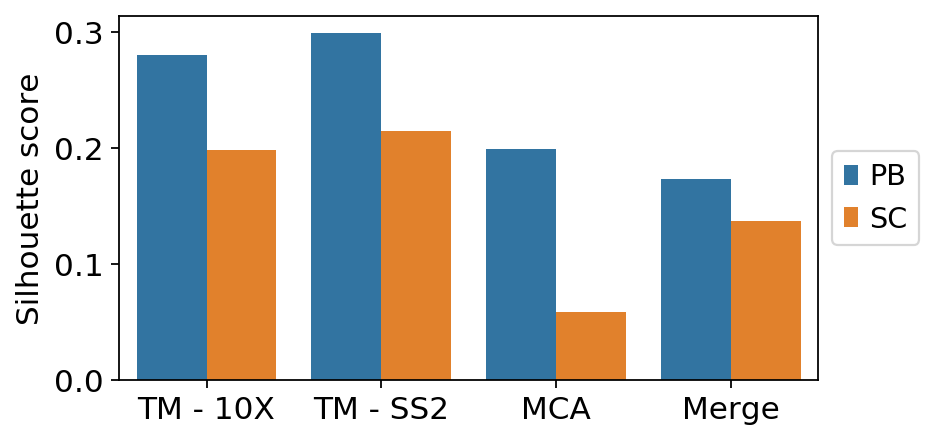

In [32]:
#Regulon
plt.figure(figsize=(7,3))
ax = sns.barplot(y = 'Silhuette_value', x = 'Method', hue = 'single_PB',
                 data = silhuette)
plt.xlabel('')
plt.ylabel('Silhouette score')
plt.grid(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('figures/Silhouette.pdf')

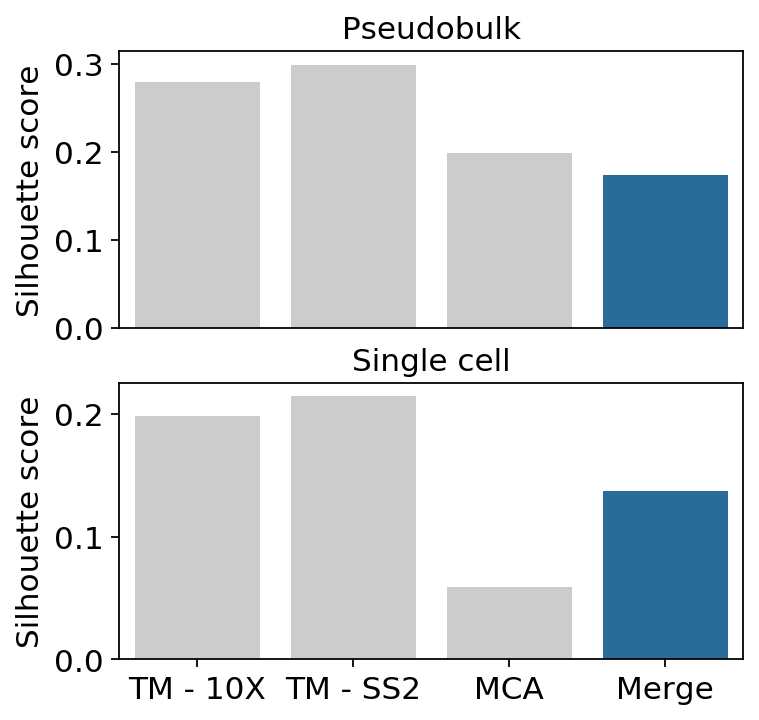

In [33]:
#Regulon
fig, axs = plt.subplots(2,1, figsize = (5,5))
axs = np.ravel(axs)

sns.barplot(y = 'Silhuette_value', x = 'Method', data = silhuette[silhuette.single_PB == 'PB'],
           ax = axs[0], palette = ["#cccccc", "#cccccc", "#cccccc", "#1770ab"])
axs[0].set_xlabel('')
axs[0].set_xticks([])
sns.barplot(y = 'Silhuette_value', x = 'Method', data = silhuette[silhuette.single_PB == 'SC'],
           ax = axs[1], palette = ["#cccccc", "#cccccc", "#cccccc", "#1770ab"])
axs[0].set_title('Pseudobulk')
axs[1].set_title('Single cell')
plt.xlabel('')
axs[0].set_ylabel('Silhouette score')
axs[1].set_ylabel('Silhouette score')
axs[0].grid(False)
axs[1].grid(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.savefig('figures/Silhouette_individual_vs_integrated.pdf')

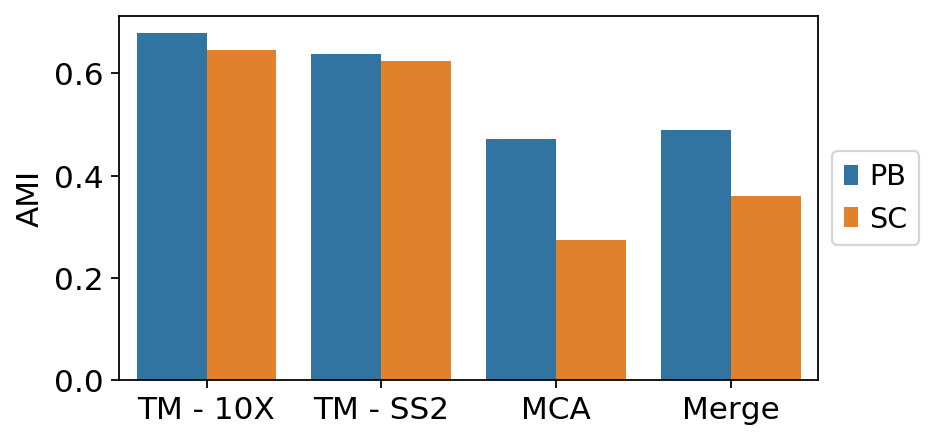

In [34]:
plt.figure(figsize=(7,3))
ax = sns.barplot(y = 'ami', x = 'Method', hue= 'single_pb', data = ami)#, palette=pal)
plt.ylabel('AMI')
plt.xlabel('')
plt.legend().remove()
plt.grid(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#plt.savefig('figures/ami.pdf')

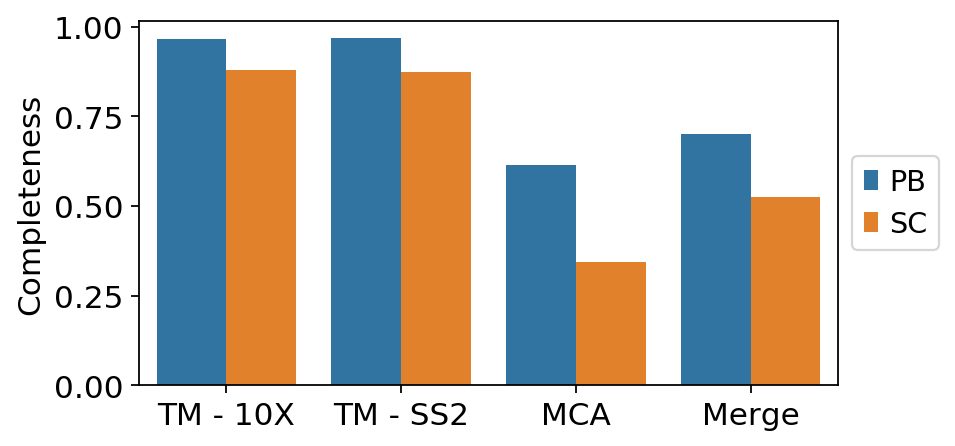

In [35]:
plt.figure(figsize=(7,3))
ax = sns.barplot(y = 'Completeness', x = 'Method', hue= 'single_pb', data = complete)#, palette=pal)
plt.ylabel('Completeness')
plt.xlabel('')
plt.legend().remove()
plt.grid(False)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#plt.savefig('figures/completeness.pdf')


## Single cell and pseudobulk overlap on PCA

In [32]:
# Make paletes for color overlay
colormap_ct = {x:y for x,y in zip(mapping_df.celltype, mapping_df.color_grad)}
colormap_super = {x:y for x,y in zip(mapping_df.Super_type, mapping_df.color_cat)}

#Compute distances
import math  
def calculateDistance(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist  

#Compute centroids
def centroids(pca, label, anno, centroids_of):
    df = pd.concat([pd.DataFrame(pca, index =label.index, columns = ['PC1_' + anno, 'PC2_' + anno]), label], axis = 1)
    df.columns = ['PC1_' + anno, 'PC2_' + anno, centroids_of]
    return df.groupby(centroids_of).mean().reset_index()

#Calculate distance to centroids
def calc_dist_to_centroids(centroids, pca, anno, label, centroids_of):
    centroids.index = centroids[centroids_of]
    centers = centroids.drop(centroids_of, axis = 1)
    
    temp = pd.DataFrame(pca, columns =['x', 'y'], index = label)
    temp[centroids_of] = label.tolist()
    temp = pd.concat([temp, temp[centroids_of].apply(lambda x: centers.loc[x])], axis = 1)
    temp['distance'] = [calculateDistance(x1, y1, x2, y2)   for x1, y1, x2, y2 in zip(temp['x'], temp['y'], temp['PC1_' + anno], temp['PC2_' + anno])]
    return temp
    
#Plot the centroids
def plot_centroids(datasets, labels, colormap, centroids_of, ax):
    pcas = run_pca(*datasets)
    pca = centroids(pcas[0], labels[0], 'full', centroids_of)
    distances_sc = calc_dist_to_centroids(pca, pcas[0], 'full', labels[0], centroids_of)
    ax.scatter(pca['PC1_full'], pca['PC2_full'], c = pca[centroids_of].map(colormap), label = 'SC')
    pca2 = centroids(pcas[1], labels[1], 'pb', centroids_of)
    distances_pb = calc_dist_to_centroids(pca2, pcas[1], 'pb', labels[1], centroids_of)
    ax.scatter(pca2['PC1_pb'], pca2['PC2_pb'], c = pca2[centroids_of].map(colormap), marker = '*', label = 'PB')
    
    
    pca.index =pca[centroids_of]
    pca2.index = pca2[centroids_of]
    links = pd.concat([pca, pca2], axis = 1)
    links.dropna(axis = 0, inplace = True)
    for i in links.index:
        ax.plot(links.loc[i][['PC1_full', 'PC1_pb']], links.loc[i][['PC2_full', 'PC2_pb']], 'k-')
    return distances_sc, distances_pb

#Run PCA on PS and project single cell onto embedding
def run_pca(full_data, pb_data):
    pca = PCA(2)  # project from 64 to 2 dimensions
    pca.fit(pb_data)

    X_pca_pb = pca.transform(pb_data)
    X_pca = pca.transform(full_data)
    return [X_pca, X_pca_pb]




### Plotting

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



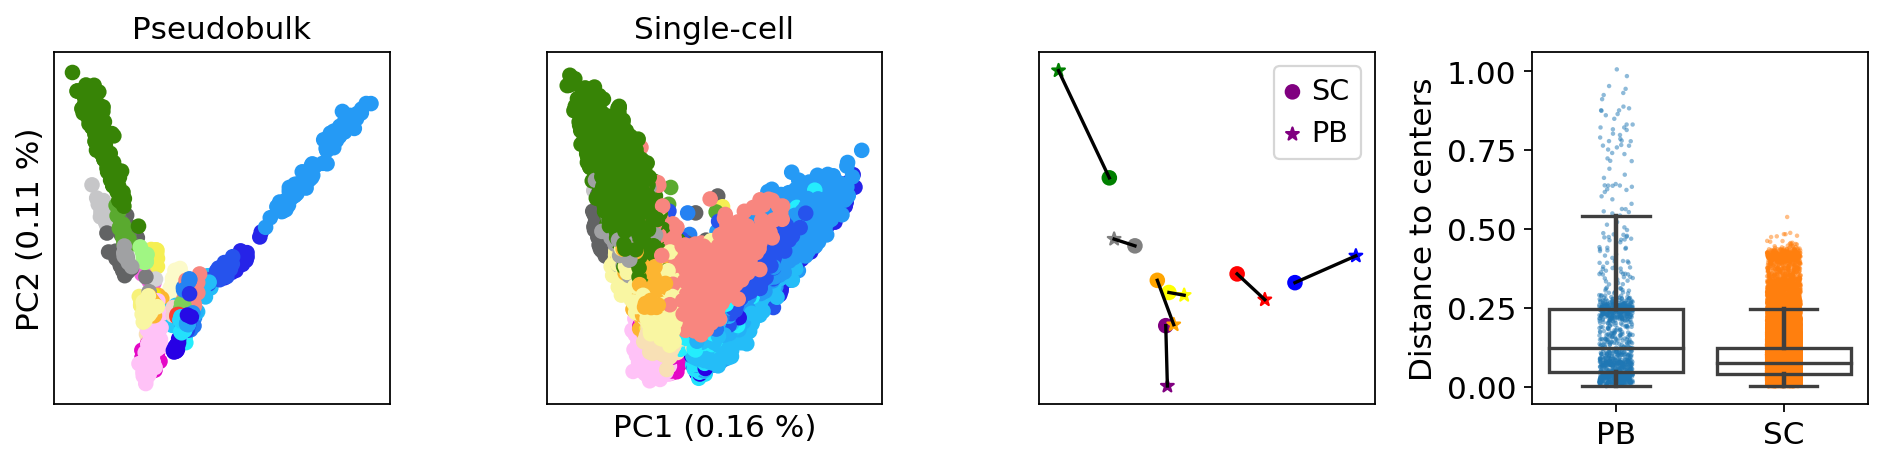

In [37]:
pca = PCA(2)  # Retain only 2 principal components
pca.fit(pb_droplet_mtx)
X_pca = pca.transform(pb_droplet_mtx)
var_exp = pca.explained_variance_ratio_
fig, axs = plt.subplots(1, 4, figsize=(12,3))
axs = axs.ravel()

axs[0].scatter(X_pca[:, 0], X_pca[:, 1],c = droplet_PB.obs.celltype.map(colormap_ct))
axs[0].set_xlabel('')
axs[0].set_ylabel('PC2 ({} %)'.format(round(var_exp[1], 2)))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Pseudobulk')
#plt.grid(False)


X_pca = pca.transform(droplet_mtx)

axs[1].scatter(X_pca[:, 0], X_pca[:, 1],c = droplet.obs.celltype.map(colormap_ct))
axs[1].set_xlabel('PC1 ({} %)'.format(round(var_exp[0], 2)))
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Single-cell')

centroids_of = 'Super'
    
droplet_dist_sc, droplet_dist_pb = plot_centroids([droplet_mtx, pb_droplet_mtx], [droplet.obs[centroids_of], droplet_PB.obs[centroids_of]], colormap_super, centroids_of=centroids_of, ax = axs[2])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].legend()


droplet_dist_pb['type'] = 'PB'
droplet_dist_sc['type'] = 'SC'

sns.stripplot(y = 'distance', x = 'type', data = pd.concat([droplet_dist_pb.drop(centroids_of,axis = 1).reset_index(), 
                                                          droplet_dist_sc.drop(centroids_of,axis = 1).reset_index()],
                                                         axis = 0, ignore_index = True), ax = axs[3], alpha = 0.5, size = 2, zorder = 0.5)

sns.boxplot(y = 'distance', x = 'type', data = pd.concat([droplet_dist_pb.drop(centroids_of,axis = 1).reset_index(), 
                                                          droplet_dist_sc.drop(centroids_of,axis = 1).reset_index()],
                                                          axis = 0, ignore_index = True), ax = axs[3],
                                                          boxprops={'facecolor':'None', "zorder":10},
                                                          showfliers=False,whiskerprops={'linewidth':2, "zorder":10},
                                                          zorder=10)


axs[3].set_ylabel('Distance to centers')
axs[3].set_xlabel('')
axs[3].grid(False)

#axs[3].set_position(box)
#axs[3].set_position([box.x0, box.y0, box.width * 0.5, box.height])
plt.subplots_adjust(top=0.9, wspace = 0.2)
#fig.suptitle('Single cell vs pseudobulk - TM - 10X', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('figures/PCA_cluster_centers_distance_droplet.pdf')




In [ ]:
col = {'endothelial cell':['#f7ba1e', '#f7991e'],
 'immune':['#33bbf5','#3350f5'],
 'basal cell':['#c11ef7','#831ef7'],
 'blood cell':['#ff634f','#f7371e'],
 'stem cell':['#72e368', '#10ad02'],
 'specialized':['#c4c4c4','#858585'],
 'epithelial cell':['#eaed82', '#dbe03d']}

droplet_dist_pb['type'] = 'PB'
droplet_dist_sc['type'] = 'SC'


for i in droplet_dist_pb.Super.unique():
    fig, ax = plt.subplots(1, 1, figsize=(2,3))

    sns.stripplot(y = 'distance', x = 'type', data = pd.concat([droplet_dist_pb[droplet_dist_pb.Super == i].drop(centroids_of,axis = 1).reset_index(), 
                                                              droplet_dist_sc[droplet_dist_sc.Super == i].drop(centroids_of,axis = 1).reset_index()],
                                                             axis = 0, ignore_index = True), ax = ax, alpha = 0.5, size = 2, zorder = 0.5,rasterized=True,
                                                                palette=col[i])

    sns.boxplot(y = 'distance', x = 'type', data = pd.concat([droplet_dist_pb[droplet_dist_pb.Super == i].drop(centroids_of,axis = 1).reset_index(), 
                                                              droplet_dist_sc[droplet_dist_sc.Super == i].drop(centroids_of,axis = 1).reset_index()],
                                                              axis = 0, ignore_index = True), ax = ax,
                                                              boxprops={'facecolor':'None', "zorder":10},
                                                              showfliers=False,whiskerprops={'linewidth':2, "zorder":10},
                                                              zorder=10)


    ax.set_ylabel('Distance to centers')
    ax.set_xlabel('')
    ax.grid(False)
    ax.set_title(i)
    plt.savefig('figures/PCA_{}_distance_droplet.pdf'.format(i),  dpi = 500)




In [38]:
droplet_tab = pd.concat([droplet_PB.obs.groupby('Super').count()['n_counts'], droplet.obs.groupby('Super').count()['n_counts']], axis = 1)
droplet_tab.columns = ['PB', 'SC']
droplet_tab

,PB,SC
Super,,
basal cell,156,7892
blood cell,30,1559
endothelial cell,71,3725
epithelial cell,89,4636
immune,385,20133
specialized,138,7190
stem cell,192,9730


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



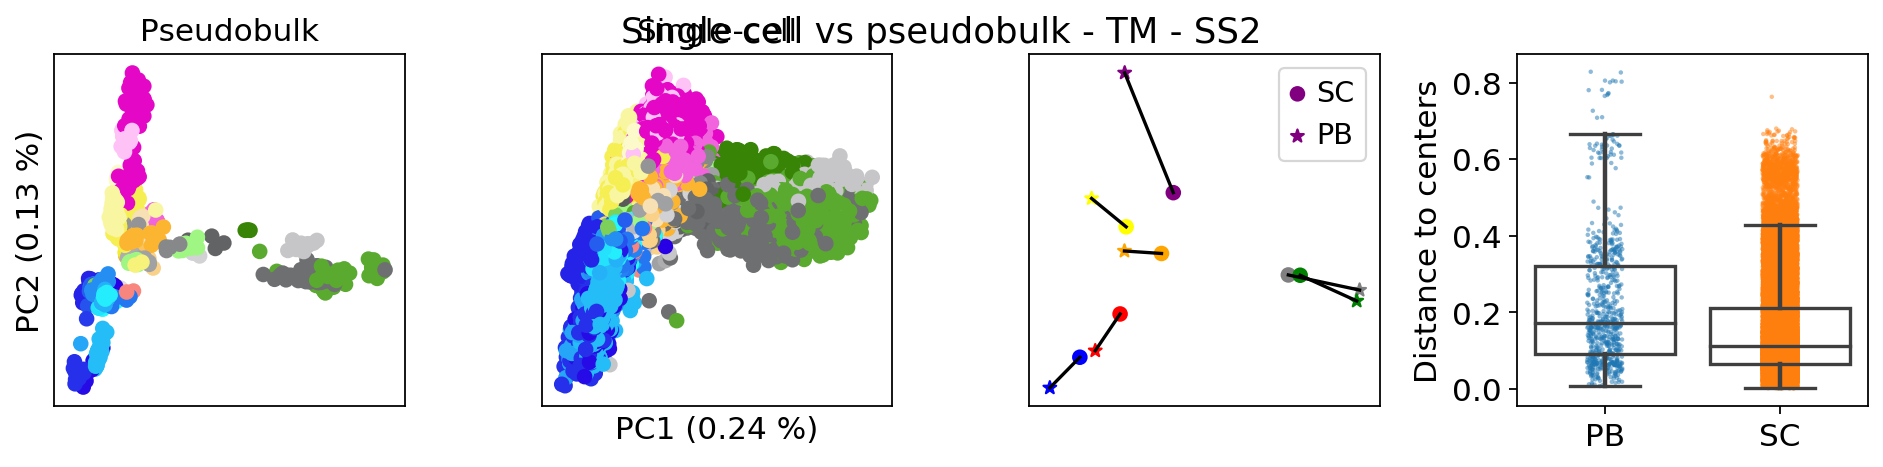

In [39]:
pca = PCA(2)  # Retain only 2 principal components
pca.fit(pb_facs_mtx)
X_pca = pca.transform(pb_facs_mtx)
var_exp = pca.explained_variance_ratio_

fig, axs = plt.subplots(1, 4, figsize=(12,3))
axs = axs.ravel()
fig.suptitle('Single cell vs pseudobulk - TM - SS2', fontsize=16)


axs[0].scatter(X_pca[:, 0], X_pca[:, 1],c = facs_PB.obs.celltype.map(colormap_ct))
axs[0].set_xlabel('')
axs[0].set_ylabel('PC2 ({} %)'.format(round(var_exp[1], 2)))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Pseudobulk')

X_pca = pca.transform(facs_mtx)

axs[1].scatter(X_pca[:, 0], X_pca[:, 1],c = facs.obs.celltype.map(colormap_ct))
axs[1].set_xlabel('PC1 ({} %)'.format(round(var_exp[0], 2)))
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Single-cell')


    
centroids_of = 'Super'
    
facs_dist_sc, facs_dist_pb = plot_centroids([facs_mtx, pb_facs_mtx], [facs.obs[centroids_of], facs_PB.obs[centroids_of]], colormap_super, centroids_of=centroids_of, ax = axs[2])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].legend()


facs_dist_pb['type'] = 'PB'
facs_dist_sc['type'] = 'SC'

sns.stripplot(y = 'distance', x = 'type', data = pd.concat([facs_dist_pb.drop(centroids_of,axis = 1).reset_index(), 
                                                          facs_dist_sc.drop(centroids_of,axis = 1).reset_index()],
                                                         axis = 0, ignore_index = True), ax = axs[3], alpha = 0.5, size = 2)

sns.boxplot(y = 'distance', x = 'type', data = pd.concat([facs_dist_pb.drop(centroids_of,axis = 1).reset_index(), 
                                                          facs_dist_sc.drop(centroids_of,axis = 1).reset_index()],
                                                          axis = 0, ignore_index = True), ax = axs[3],
                                                          boxprops={'facecolor':'None', "zorder":10},
                                                          showfliers=False,whiskerprops={'linewidth':2, "zorder":10},
                                                          zorder=10)
axs[3].set_ylabel('Distance to centers')
axs[3].set_xlabel('')
axs[3].grid(False)

#axs[3].set_position(box)
#axs[3].set_position([box.x0, box.y0, box.width * 0.5, box.height])
plt.subplots_adjust(top=0.9, wspace = 0.2)
#fig.suptitle('Single cell vs pseudobulk - TM - SS2', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('figures/PCA_cluster_centers_distance_facs.pdf')


In [ ]:
col = {'endothelial cell':['#f7ba1e', '#f7991e'],
 'immune':['#33bbf5','#3350f5'],
 'basal cell':['#c11ef7','#831ef7'],
 'blood cell':['#ff634f','#f7371e'],
 'stem cell':['#72e368', '#10ad02'],
 'specialized':['#c4c4c4','#858585'],
 'epithelial cell':['#eaed82', '#dbe03d']}

facs_dist_pb['type'] = 'PB'
facs_dist_sc['type'] = 'SC'


for i in facs_dist_pb.Super.unique():
    fig, ax = plt.subplots(1, 1, figsize=(2,3))

    sns.stripplot(y = 'distance', x = 'type', data = pd.concat([facs_dist_pb[facs_dist_pb.Super == i].drop(centroids_of,axis = 1).reset_index(), 
                                                              facs_dist_sc[facs_dist_sc.Super == i].drop(centroids_of,axis = 1).reset_index()],
                                                             axis = 0, ignore_index = True), ax = ax, alpha = 0.5, size = 2, zorder = 0.5,rasterized=True,
                                                                palette=col[i])

    sns.boxplot(y = 'distance', x = 'type', data = pd.concat([facs_dist_pb[facs_dist_pb.Super == i].drop(centroids_of,axis = 1).reset_index(), 
                                                              facs_dist_sc[facs_dist_sc.Super == i].drop(centroids_of,axis = 1).reset_index()],
                                                              axis = 0, ignore_index = True), ax = ax,
                                                              boxprops={'facecolor':'None', "zorder":10},
                                                              showfliers=False,whiskerprops={'linewidth':2, "zorder":10},
                                                              zorder=10)


    ax.set_ylabel('Distance to centers')
    ax.set_xlabel('')
    ax.grid(False)
    ax.set_title(i)
    plt.savefig('figures/PCA_{}_distance_facs.pdf'.format(i),  dpi = 500)




In [40]:
facs_tab = pd.concat([facs_PB.obs.groupby('Super').count()['n_counts'], facs.obs.groupby('Super').count()['n_counts']], axis = 1)
facs_tab.columns = ['PB', 'SC']
facs_tab

,PB,SC
Super,,
basal cell,98,5029
blood cell,6,396
endothelial cell,70,3896
epithelial cell,114,6104
immune,206,11906
specialized,98,5659
stem cell,111,5898


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



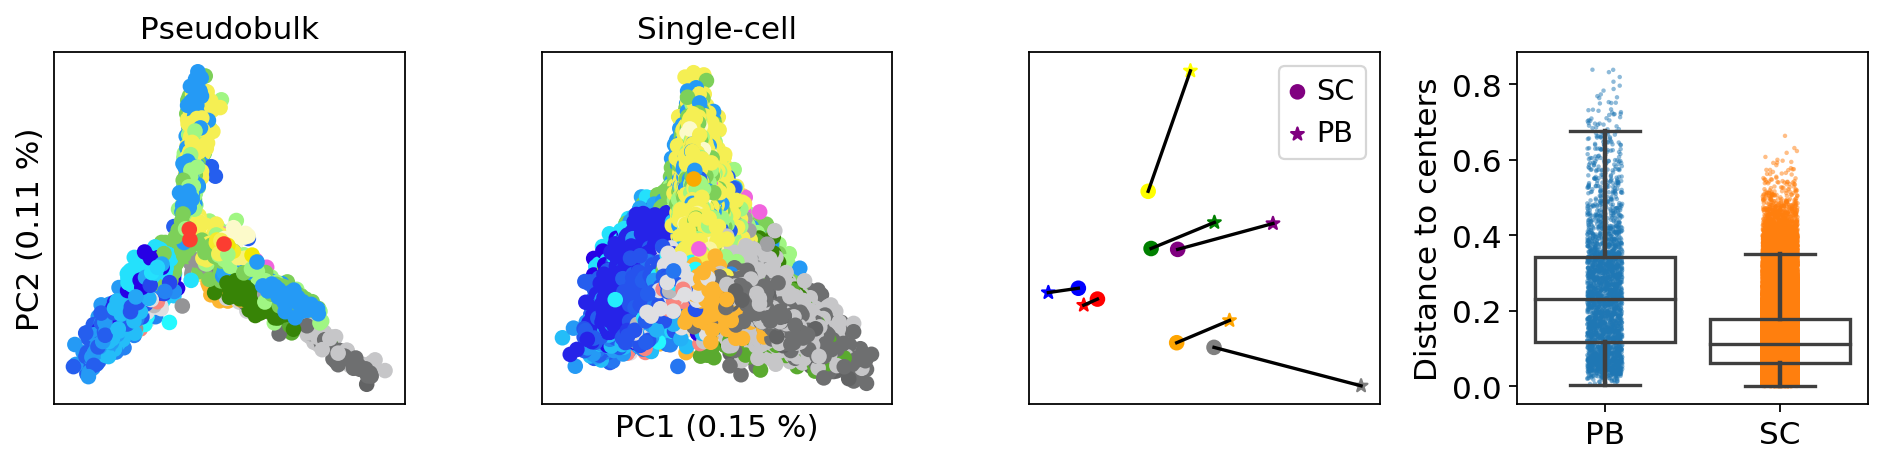

In [41]:
pca = PCA(2)  # Retain only 2 principal components
pca.fit(pb_mca_mtx)
X_pca = pca.transform(pb_mca_mtx)
var_exp = pca.explained_variance_ratio_

fig, axs = plt.subplots(1, 4, figsize=(12,3))
axs = axs.ravel()

axs[0].scatter(X_pca[:, 0], X_pca[:, 1],c = mca_PB.obs.celltype.map(colormap_ct))
axs[0].set_xlabel('')
axs[0].set_ylabel('PC2 ({} %)'.format(round(var_exp[1], 2)))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Pseudobulk')

X_pca = pca.transform(mca_mtx)

axs[1].scatter(X_pca[:, 0], X_pca[:, 1],c = mca.obs.celltype.map(colormap_ct))
axs[1].set_xlabel('PC1 ({} %)'.format(round(var_exp[0], 2)))
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Single-cell')


    
centroids_of = 'Super'
    
mca_dist_sc, mca_dist_pb = plot_centroids([mca_mtx, pb_mca_mtx], [mca.obs[centroids_of], mca_PB.obs[centroids_of]], colormap_super, centroids_of=centroids_of, ax = axs[2])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].legend()


mca_dist_pb['type'] = 'PB'
mca_dist_sc['type'] = 'SC'

sns.stripplot(y = 'distance', x = 'type', data = pd.concat([mca_dist_pb.drop(centroids_of,axis = 1).reset_index(), 
                                                          mca_dist_sc.drop(centroids_of,axis = 1).reset_index()],
                                                         axis = 0, ignore_index = True), ax = axs[3], alpha = 0.5, size = 2)

sns.boxplot(y = 'distance', x = 'type', data = pd.concat([mca_dist_pb.drop(centroids_of,axis = 1).reset_index(), 
                                                          mca_dist_sc.drop(centroids_of,axis = 1).reset_index()],
                                                          axis = 0, ignore_index = True), ax = axs[3],
                                                          boxprops={'facecolor':'None', "zorder":10},
                                                          showfliers=False,whiskerprops={'linewidth':2, "zorder":10},
                                                          zorder=10)
axs[3].set_ylabel('Distance to centers')
axs[3].set_xlabel('')
axs[3].grid(False)

#axs[3].set_position(box)
#axs[3].set_position([box.x0, box.y0, box.width * 0.5, box.height])
plt.subplots_adjust(top=0.9, wspace = 0.2)
#fig.suptitle('Single cell vs pseudobulk - MCA', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('figures/PCA_cluster_centers_distance_mca.pdf')

In [ ]:
col = {'endothelial cell':['#f7ba1e', '#f7991e'],
 'immune':['#33bbf5','#3350f5'],
 'basal cell':['#c11ef7','#831ef7'],
 'blood cell':['#ff634f','#f7371e'],
 'stem cell':['#72e368', '#10ad02'],
 'specialized':['#c4c4c4','#858585'],
 'epithelial cell':['#eaed82', '#dbe03d']}

mca_dist_pb['type'] = 'PB'
mca_dist_sc['type'] = 'SC'


for i in mca_dist_pb.Super.unique():
    fig, ax = plt.subplots(1, 1, figsize=(2,3))

    sns.stripplot(y = 'distance', x = 'type', data = pd.concat([mca_dist_pb[mca_dist_pb.Super == i].drop(centroids_of,axis = 1).reset_index(), 
                                                              mca_dist_sc[mca_dist_sc.Super == i].drop(centroids_of,axis = 1).reset_index()],
                                                             axis = 0, ignore_index = True), ax = ax, alpha = 0.5, size = 2, zorder = 0.5,rasterized=True,
                                                                palette=col[i])

    sns.boxplot(y = 'distance', x = 'type', data = pd.concat([mca_dist_pb[mca_dist_pb.Super == i].drop(centroids_of,axis = 1).reset_index(), 
                                                              mca_dist_sc[mca_dist_sc.Super == i].drop(centroids_of,axis = 1).reset_index()],
                                                              axis = 0, ignore_index = True), ax = ax,
                                                              boxprops={'facecolor':'None', "zorder":10},
                                                              showfliers=False,whiskerprops={'linewidth':2, "zorder":10},
                                                              zorder=10)


    ax.set_ylabel('Distance to centers')
    ax.set_xlabel('')
    ax.grid(False)
    ax.set_title(i)
    plt.savefig('figures/PCA_{}_distance_mca.pdf'.format(i),  dpi = 500)




In [42]:
mca_tab = pd.concat([mca_PB.obs.groupby('Super').count()['n_counts'], mca.obs.groupby('Super').count()['n_counts']], axis = 1)
mca_tab.columns = ['PB', 'SC']
mca_tab

,PB,SC
Super,,
basal cell,7,473
blood cell,10,970
endothelial cell,17,1292
epithelial cell,381,19920
immune,1111,61422
specialized,243,14229
stem cell,1007,52583
